# Parsing Raw Data from GPS (.txt files)

In [3]:
import csv
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import chardet

### Helper Functions for parsing raw GPS data 

In [4]:
def read_lines_auto(path):
    '''
    Function that simplifies calling and reading a file. Also detects and handles different encodings (utf-8, utf-16, etc.).
    '''
    with open(path, "rb") as f:
        raw = f.read()
    encoding = chardet.detect(raw)["encoding"]
    return raw.decode(encoding).splitlines()

def parse_file(input_file, output_file):
    '''
    Parses the txt files (raw data) from the GPS 
    '''
    rows = []
    lines = read_lines_auto(input_file)

    for line in lines:
        line = line.strip() #Removes leading/trailing whitespace from string (which is a line in the txt file)
        if not line:
            continue

        #Parsing .txt files which use WGS84. It seems the GPS device on a wheel uses this coordinate type. 
        if line.startswith("GPS"): #The GPS txt file's rows always start with "GPS...". 
            parts = re.split(r"\s+", line)
            if len(parts) < 6:
                continue  #A row contaning complete data should have 6 values, if less it is malformed and thus skipped
            try:
                fid = parts[0]      #The files value in a row is the FID of the GPS data (its label)
                x = float(parts[3]) #WGS84 X Coordinate Value
                y = float(parts[4]) #WGS84 Y Coordinate Value
                z = float(parts[5]) #Altitude 
            except ValueError:
                continue

        #Parsing .txt files which use RD New Coordinates. 
        else:
            parts = line.split(";")
            if parts[0] == "FID" or len(parts) < 5:
                continue
            try:
                fid = parts[0]          #FID column
                x = float(parts[2])
                y = float(parts[3])
                z = float(parts[4])
            except ValueError:
                continue

        rows.append([fid, x, y, z])

    with open(output_file, "w", newline="", encoding="utf-8") as f: #Writes parsed data into a csv file. This is a easy format to work with in pandas, or QGIS.
        writer = csv.writer(f)
        writer.writerow(["FID", "X", "Y", "Z"])
        writer.writerows(rows)


### Run parse_file function

In [5]:
parse_file(
    input_file=r"C:\Users\keisi\OneDrive\Documents\Stormtroopers\test data\24OctGPS_2.txt",
    output_file=r"C:\Users\keisi\OneDrive\Documents\Stormtroopers\test data\Output Data\24OctGPS_2_parsed.csv"
)

# Transect Analysis

## Part 1 : Use total least square to determine representative transect

Since the collected transect data does not overlap perfectly, we must decide a representative transect on which to overlay the measured results. This is done through total least squares, which takes the straight line which is "least far away" from the points overall.

### Define necessary functions (loading data, choosing which segments of the data to use)

In [6]:
def load_xyz_by_fid(csv_file):
    '''
    Loads the data from the parsed CSV into a dictionary, where the data is stored with its FID as its key, and x,y,z as its values 
    '''
    data = {}
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            fid = int(row["FID"])
            data[fid] = {
                "x": float(row["X"]),
                "y": float(row["Y"]),
                "z": float(row["Z"]),
            }
    return data

def extract_xyz_fid_segment(data, start_fid, end_fid):
    '''
    Function which outputs the x,y,z values for the data points in the indicated FID range. 
    '''
    step = -1 if start_fid > end_fid else 1
    fids = [fid for fid in range(start_fid, end_fid + step, step) if fid in data]
    x = np.array([data[fid]['x'] for fid in fids])
    y = np.array([data[fid]['y'] for fid in fids])
    z = np.array([data[fid]['z'] for fid in fids])
    return x,y,z

def organize_transects(data, ranges):
    '''
    Function which organizes the data extracted from the above into a more easily callable tuple.
    '''
    transects = []
    for i in range(0, len(ranges), 2):
        t1 = extract_xyz_fid_segment(data, ranges[i][0], ranges[i][1])
        t2 = extract_xyz_fid_segment(data, ranges[i+1][0], ranges[i+1][1])
        transects.append([t1, t2])
    return transects
        #Outputs: transects[transect number][sample_date][x/y/z]


### Define Data Source and Segments (FID)

In [7]:
#FID Segments of the Transects
file = r"C:\Users\keisi\OneDrive\Documents\Stormtroopers\test data\Output Data\24OctGPS_2_parsed.csv"
data = load_xyz_by_fid(file)

#Using QGIS, we can see which data points geographically correspond to which FID values, we can then indicate the starting and end values of the transect.
#If possible, ensure the direction of the transect is the same for both ranges you indicate
segment_ranges = (
    [127,76] , [3053,3114], #Transect 1 (24 Oct, 30 Oct)
    [254,201], [2937,2993], #Transect 2 ""
    [399,331], [2891,2826], #Transect 3 "" 
    [529,489], [2712,2759], #Transect 4 ""
    [678,625], [2613,2665], #Transect 5 ""
    [822,851], [2536,2489]  #Transect 6 ""
)

transects = organize_transects(data, segment_ranges)

### (Helper Function) Least Squares to find straight line which "closest" to both transects

In [8]:
def fit_tls_line(x, y):
    """
    Orthogonal least-squares line fit (Total Least Squares).
    Returns (centroid, direction_vector).
    """
    points = np.column_stack((x, y))
    centroid = points.mean(axis=0) #Calculate the centroid x, y, from the points of both transects

    # PCA via SVD
    _, _, vh = np.linalg.svd(points - centroid) #Extracts the directions of the data from the centroid point. 
    direction = vh[0] #Takes the first principal component as the direction vector. The "strongest" direction of the data.

    return centroid, direction

### (Optional) Plot the Transects (x-y)

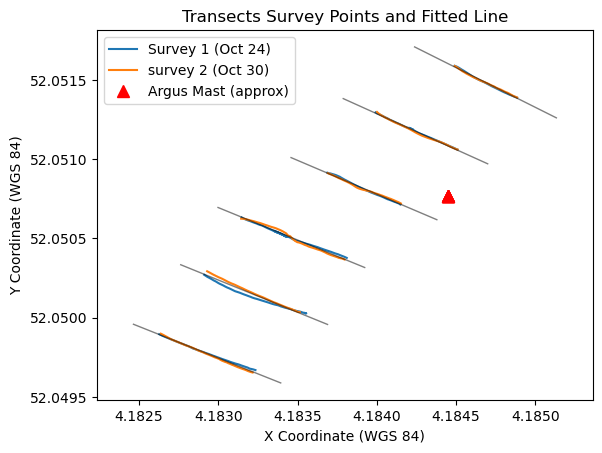

In [9]:
for i in range(len(segment_ranges)//2):
    #X and Y values of the transect from survey 1 
    x1 = np.array(transects[i][0][0])
    y1 = np.array(transects[i][0][1])

    #X and Y values of the transect from survey 2
    x2 = np.array(transects[i][1][0])
    y2 = np.array(transects[i][1][1])

    #Plotting Survey Points 
    plt.plot(x1, y1, color="tab:blue", label="Survey 1 (Oct 24)" if i == 0 else "")
    plt.plot(x2, y2, color="tab:orange", label="survey 2 (Oct 30)" if i == 0 else "")

    #Plot argus mast
    x_argus = 4.184447
    y_argus = 52.050765
    plt.plot(x_argus, y_argus, "r^", markersize=8, label="Argus Mast (approx)" if i == 0 else "")

    # Combine both lines
    x_all = np.concatenate([x1, x2])
    y_all = np.concatenate([y1, y2])

    # Fit representative line
    center, direction = fit_tls_line(x_all, y_all)

    # Generate points for plotting
    t = np.linspace(-0.0005, 0.0005, 100)
    x_fit = center[0] + t * direction[0]
    y_fit = center[1] + t * direction[1]

    plt.plot(x_fit, y_fit, "k-", linewidth=1, alpha=0.5) #COMMENT THIS OUT TO REMOVE THE LEAST SQUARES LINE
    plt.axis("equal")
    plt.title(f"Transects Survey Points and Fitted Line")
    plt.xlabel("X Coordinate (WGS 84)")
    plt.ylabel("Y Coordinate (WGS 84)")
    plt.legend()


## Part 2 : Extrapolate measured altitude onto the representative transect

### Helper Functions

In [13]:

def project_to_local_meters(x, y, method="utm"):
    """Project lon/lat arrays (x=lon, y=lat in degrees) to meters."""
    x = np.asarray(x)
    y = np.asarray(y)
    lon0, lat0 = float(x.mean()), float(y.mean())
    if method == "utm":
        zone = int((lon0 + 180) / 6) + 1
        epsg = 32600 + zone if lat0 >= 0 else 32700 + zone
        transformer = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}", always_xy=True)
    else:
        proj_str = f"+proj=aeqd +lat_0={lat0} +lon_0={lon0} +units=m +ellps=WGS84"
        transformer = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True)
    xm, ym = transformer.transform(x, y)
    return np.array(xm), np.array(ym)

def unit(v):
    return v / np.linalg.norm(v) #Creates unit vector of input vector v (used to make a 1m vector in the direction of the transect line)

def project_points_onto_line(x, y, z, center, direction):
    """Projects points onto a line; returns distance along line, z-values, and lateral offsets"""
    d = unit(direction)
    points = np.column_stack((x, y))
    rel = points - center
    t_vals = rel @ d                  #Calculates the distance along the transect line with dot product
    normal = np.array([-d[1], d[0]])  #
    offset = rel @ normal             #Lateral distance from transect
    return t_vals, z, offset


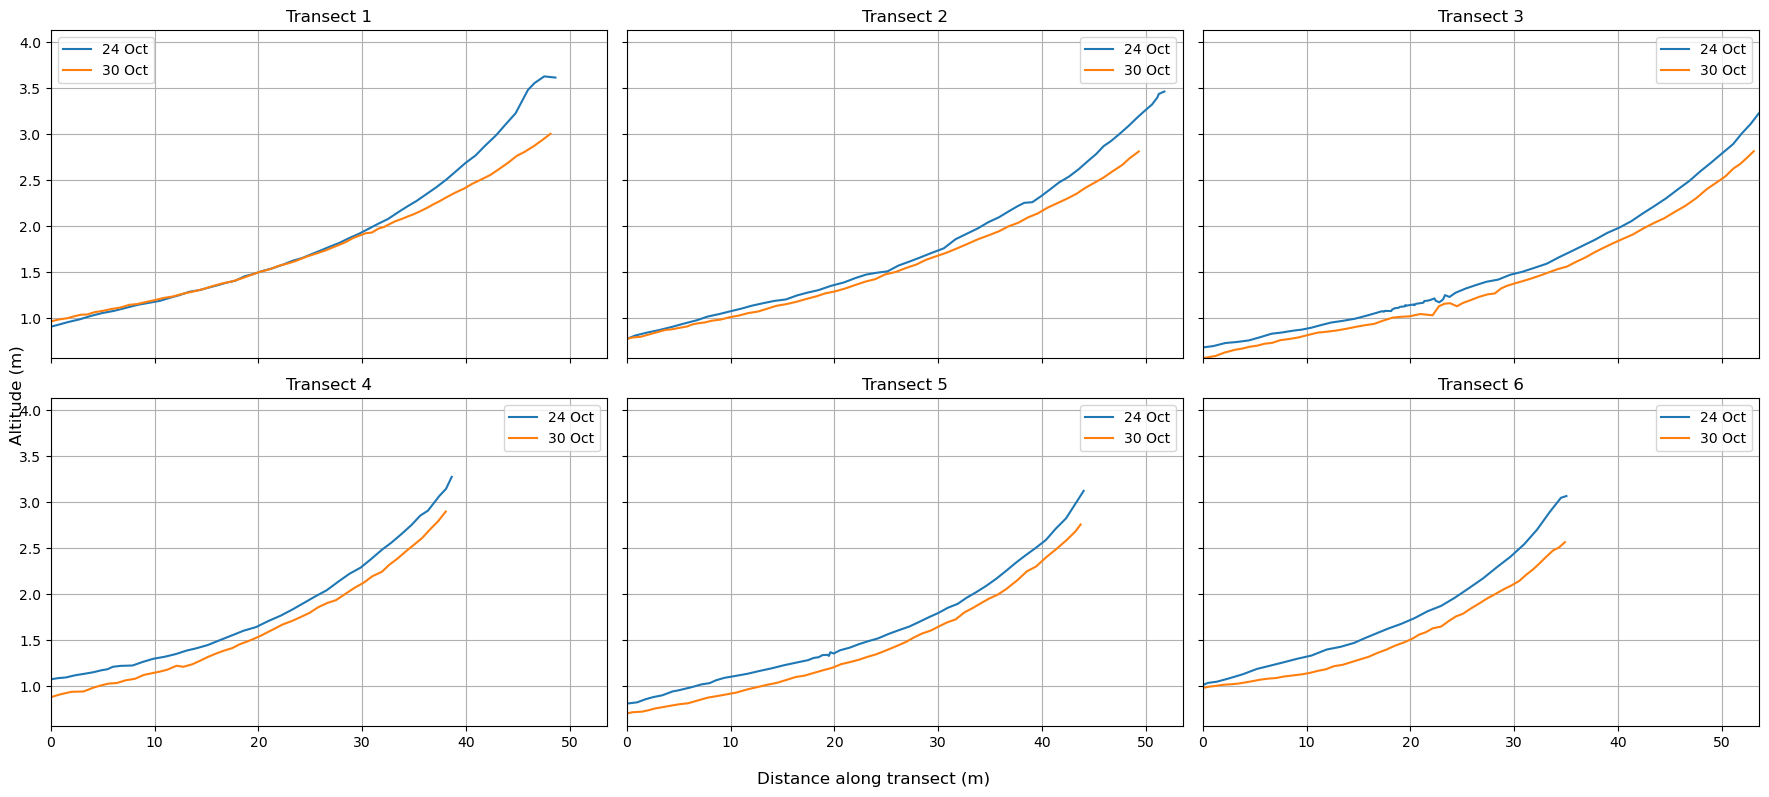

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Keep track of global min/max for consistent x/y limits
all_t = []
all_z = []

for i in range(len(segment_ranges)//2):
    ax = axes[i]

    # --- Extract measured data ---
    x1 = np.array(transects[i][0][0])
    y1 = np.array(transects[i][0][1])
    z1 = np.array(transects[i][0][2])

    x2 = np.array(transects[i][1][0])
    y2 = np.array(transects[i][1][1])
    z2 = np.array(transects[i][1][2])

    # --- Fit representative transect and project to meters ---
    # Convert lon/lat to local metric coordinates (meters) before fitting/projection
    try:
        x1_m, y1_m = project_to_local_meters(x1, y1, method="utm")
        x2_m, y2_m = project_to_local_meters(x2, y2, method="utm")
        x_all = np.concatenate([x1_m, x2_m])
        y_all = np.concatenate([y1_m, y2_m])
        center, direction = fit_tls_line(x_all, y_all)
        # --- Project points onto transect (metric) ---
        t1, z1p, offset1 = project_points_onto_line(x1_m, y1_m, z1, center, direction)
        t2, z2p, offset2 = project_points_onto_line(x2_m, y2_m, z2, center, direction)
    except Exception:
        # Fallback to original (non-metric) behavior if projection fails
        x_all = np.concatenate([x1, x2])
        y_all = np.concatenate([y1, y2])
        center, direction = fit_tls_line(x_all, y_all)
        t1, z1p, offset1 = project_points_onto_line(x1, y1, z1, center, direction)
        t2, z2p, offset2 = project_points_onto_line(x2, y2, z2, center, direction)

    # --- Shift distance to start at zero ---
    t1 -= t1.min()
    t2 -= t2.min()

    # --- Sort points along transect ---
    order1 = np.argsort(t1)
    order2 = np.argsort(t2)
    t1, z1p, offset1 = t1[order1], z1p[order1], offset1[order1]
    t2, z2p, offset2 = t2[order2], z2p[order2], offset2[order2]

    # --- Store for global x/y limits ---
    all_t.extend(t1)
    all_t.extend(t2)
    all_z.extend(z1p)
    all_z.extend(z2p)

    # --- Plot profiles ---
    ax.plot(t1, z1p, "-", color="tab:blue", label="24 Oct")
    ax.plot(t2, z2p, "-", color="tab:orange", label="30 Oct")

    ax.set_title(f"Transect {i+1}")
    ax.grid(True)
    ax.legend()

# --- Set consistent x/y limits ---
axes[0].set_xlim(min(all_t), max(all_t) + 0.0001)
axes[0].set_ylim(min(all_z), max(all_z) + 0.5)
for ax in axes[1:]:
    ax.set_xlim(min(all_t), max(all_t) + 0.0001)
    ax.set_ylim(min(all_z), max(all_z) + 0.5)

fig.supxlabel("Distance along transect (m)")
fig.supylabel("Altitude (m)")
plt.tight_layout()
plt.show()
